In [1]:
"""
Trains a GPT to add n-digit numbers.
"""

import os
import sys
import json

import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

from mingpt.model import GPT
from mingpt.trainer import Trainer
from mingpt.utils import set_seed, setup_logging, CfgNode as CN

from nndrain.tensor_edit import TensorEdit
from nndrain.simplify_linear import SimplifyLinear
import nndrain.utils as utils

In [2]:
class AdditionDataset(Dataset):
    """
    Creates n-digit addition problems. For example, if n=2, then an example
    addition problem would be to add 85 + 50 = 135. This problem would be
    represented as the following string for the GPT:

    "8550531"

    This is because:
    - we are discarding the + and =, which are not necessary. We just encode the digits
      of the input numbers concatenated together.
    - the result 135 is encoded backwards to make the addition easier to learn for the
      GPT model, because of how the addition algorithm works.

    As one more example, the problem 6 + 39 = 45 would be encoded as:

    "0639054"

    where you will notice that we are padding with zeros to make sure that we always
    produce strings of the exact same size: n + n + (n + 1). When n=2, this is 7.
    At test time, we will feed in an addition problem by giving the first 2n digits,
    and hoping that the GPT model completes the sequence with the next (n+1) digits
    correctly.
    """

    @staticmethod
    def get_default_config():
        C = CN()
        C.ndigit = 2
        return C

    def __init__(self, config, split):
        self.config = config
        self.split = split # train/test

        # split up all addition problems into either training data or test data
        ndigit = self.config.ndigit
        assert ndigit <= 3, "the lines below would be very memory inefficient, in future maybe refactor to support"
        num = (10**ndigit)**2 # total number of possible addition problems with ndigit numbers
        rng = torch.Generator()
        rng.manual_seed(1337)
        perm = torch.randperm(num, generator=rng)
        num_test = min(int(num*0.2), 500) # 20% of the whole dataset, or only up to 500
        self.ixes = perm[:num_test] if split == 'test' else perm[num_test:]

    def get_vocab_size(self):
        return 10 # digits 0..9

    def get_block_size(self):
        # a,b,a+b, and +1 due to potential carry overflow,
        # but then also -1 because very last digit doesn't ever plug back
        # as there is no explicit <EOS> token to predict, it is implied
        return 3*self.config.ndigit + 1 - 1

    def __len__(self):
        return self.ixes.nelement()

    def __getitem__(self, idx):
        ndigit = self.config.ndigit
        # given a problem index idx, first recover the associated a + b
        idx = self.ixes[idx].item()
        nd = 10**ndigit
        a = idx // nd
        b = idx %  nd
        # calculate the "label" of the addition problem a + b
        c = a + b
        # encode the digits of a, b, c into strings
        astr = f'%0{ndigit}d' % a
        bstr = f'%0{ndigit}d' % b
        cstr = (f'%0{ndigit+1}d' % c)[::-1] # reverse c to make addition easier
        render = astr + bstr + cstr
        dix = [int(s) for s in render] # convert each character to its token index
        # x will be input to GPT and y will be the associated expected outputs
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long) # predict the next token in the sequence
        y[:ndigit*2-1] = -1 # we will only train in the output locations. -1 will mask loss to zero
        return x, y

In [3]:
def get_config():

    C = CN()

    # system
    C.system = CN()
    C.system.seed = 3407
    C.system.work_dir = './out/adder'

    # data
    C.data = AdditionDataset.get_default_config()
    C.data.ndigit=2

    # model
    C.model = GPT.get_default_config()
    C.model.model_type = 'gpt-micro'

    # trainer
    C.trainer = Trainer.get_default_config()
    C.trainer.num_workers = 0
    C.trainer.learning_rate = 6e-4 # the model we're using is so small that we can go a bit faster
    C.trainer.batch_size = 512
    C.trainer.max_iters = 50000

    return C

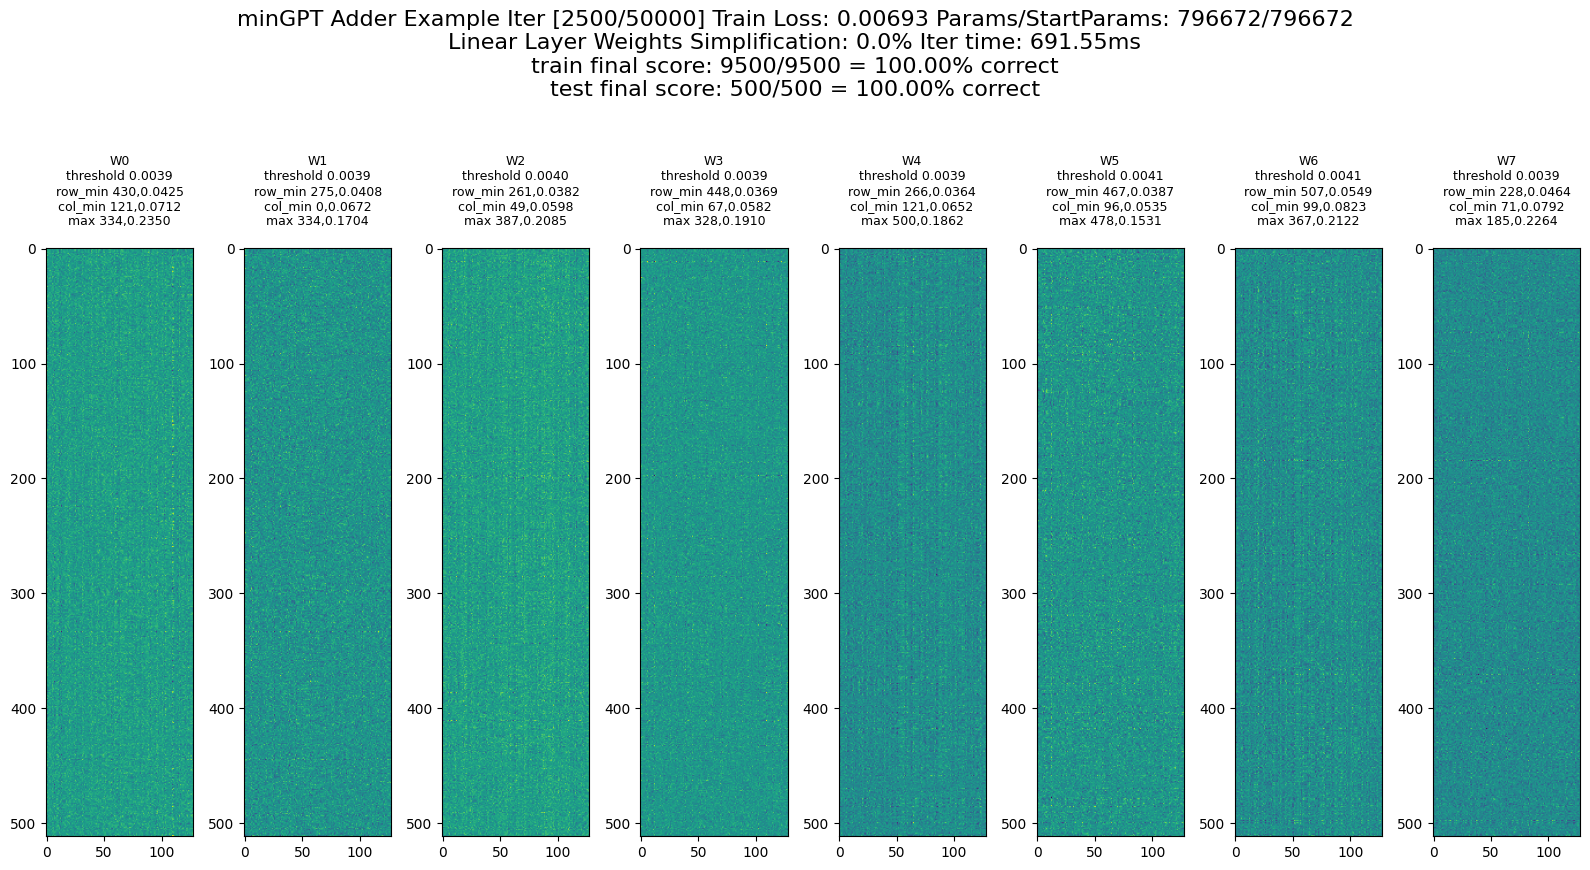

iter_dt 651.47ms; iter 2510: train loss 0.01622
iter_dt 637.84ms; iter 2520: train loss 0.01222
iter_dt 680.38ms; iter 2530: train loss 0.02320
iter_dt 639.37ms; iter 2540: train loss 0.01314
iter_dt 703.15ms; iter 2550: train loss 0.00331
iter_dt 716.73ms; iter 2560: train loss 0.01417
iter_dt 742.22ms; iter 2570: train loss 0.01331
iter_dt 713.45ms; iter 2580: train loss 0.01746
iter_dt 734.37ms; iter 2590: train loss 0.00860
iter_dt 691.16ms; iter 2600: train loss 0.00979
iter_dt 698.53ms; iter 2610: train loss 0.00782
iter_dt 647.07ms; iter 2620: train loss 0.01223
iter_dt 749.99ms; iter 2630: train loss 0.01862
iter_dt 748.33ms; iter 2640: train loss 0.01700
iter_dt 652.27ms; iter 2650: train loss 0.00979
iter_dt 708.88ms; iter 2660: train loss 0.01425
iter_dt 726.86ms; iter 2670: train loss 0.01491


In [4]:
%matplotlib inline
if __name__ == '__main__':
    # get default config and overrides from the command line, if any
    config = get_config()

    print(config)
    setup_logging(config)
    set_seed(config.system.seed)

    # construct train and test datasets
    train_dataset = AdditionDataset(config.data, split='train')
    test_dataset  = AdditionDataset(config.data, split='test')

    # construct the model
    config.model.vocab_size = train_dataset.get_vocab_size()
    config.model.block_size = train_dataset.get_block_size()
    model = GPT(config.model)

    ####################################
    n_start_params = sum(p.numel() for p in model.parameters())
    simplify_layers = [module for module in model.modules() if isinstance(module, SimplifyLinear)]
    te = TensorEdit(simplify_layers)
    drain_threshold_coeff = 3.0
    remove_threshold_coeff = 0.1
    fig, fig_chart = None, None
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(16, 10), facecolor='white')    
    filenames = []
    outdir = 'out/adder'
    ####################################

    # construct the trainer object
    trainer = Trainer(config.trainer, model, train_dataset)

    # helper function for the evaluation of a model
    def eval_split(trainer, split, max_batches=None):
        dataset = {'train':train_dataset, 'test':test_dataset}[split]
        ndigit = config.data.ndigit
        results = []
        mistakes_printed_already = 0
        factors = torch.tensor([[10**i for i in range(ndigit+1)][::-1]]).to(trainer.device)
        loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
        for b, (x, y) in enumerate(loader):
            x = x.to(trainer.device)
            # isolate the first two digits of the input sequence alone
            d1d2 = x[:, :ndigit*2]
            # let the model sample the rest of the sequence
            d1d2d3 = model.generate(d1d2, ndigit+1, do_sample=False) # using greedy argmax, not sampling
            # isolate the last digit of the sampled sequence
            d3 = d1d2d3[:, -(ndigit+1):]
            d3 = d3.flip(1) # reverse the digits to their "normal" order
            # decode the integers from individual digits
            d1i = (d1d2[:,:ndigit] * factors[:,1:]).sum(1)
            d2i = (d1d2[:,ndigit:ndigit*2] * factors[:,1:]).sum(1)
            d3i_pred = (d3 * factors).sum(1)
            d3i_gt = d1i + d2i # manually calculate the ground truth
            # evaluate the correctness of the results in this batch
            correct = (d3i_pred == d3i_gt).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line haha
            for i in range(x.size(0)):
                results.append(int(correct[i]))
                if not correct[i] and mistakes_printed_already < 5: # only print up to 5 mistakes to get a sense
                    mistakes_printed_already += 1
                    print("GPT claims that %d + %d = %d but gt is %d" % (d1i[i], d2i[i], d3i_pred[i], d3i_gt[i]))
            if max_batches is not None and b+1 >= max_batches:
                break
        rt = torch.tensor(results, dtype=torch.float)
        score_print = "%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean())
        print(score_print)
        return rt.sum(), score_print


    # iteration callback
    top_score = 0
    def batch_end_callback(trainer):
        global top_score

        epoch = int(trainer.iter_num/150) #define an arbitrary epoch just to periodically execute the underlying methods
        te.set_threshold()
        te.weights_drain(p_drain=0.1, threshold_coeff=drain_threshold_coeff, condition=epoch>20 and epoch%2==0)
        te.weights_decay(p_decay=0.1, decay_rate=5e-3, condition=epoch>20 and epoch%2==0)

        removed = False
        if trainer.iter_num % 10 == 0:
            print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")

            # remove weights if all values ​​in a row or column are less than the specified value
            if te.weights_remove(p_remove=1, threshold_coeff=remove_threshold_coeff, max_removal=1.0, verbose=True):
                # re-instantiate the optimizer with the new model if I have deleted any rows or columns
                trainer.optimizer = model.configure_optimizers(config.trainer)


        if trainer.iter_num % 250 == 0:

            # evaluate both the train and test score
            train_max_batches = {1: None, 2: None, 3: 5, 4: 5}[config.data.ndigit] # if ndigit=2 we can afford the whole train set, ow no
            model.eval()
            with torch.no_grad():
                train_score, title3 = eval_split(trainer, 'train', max_batches=train_max_batches)
                test_score, title4  = eval_split(trainer, 'test',  max_batches=None)
            score = train_score + test_score
            # save the model if this is the best score we've seen so far
            if score > top_score:
                top_score = score
                print(f"saving model with new top score of {score}")
                ckpt_path = os.path.join(config.system.work_dir, "model.pt")
                torch.save(model.state_dict(), ckpt_path)
            # revert model to training mode
            model.train()

            # plot
            n_params = sum(p.numel() for p in model.parameters())
            simplification = (1-n_params/n_start_params)*100
            print("number of parameters: {:.3e} simplification: {:.1f}%".format(n_params, simplification))

            weights = [w.weight.data.T if w.weight.data.size()[1]>w.weight.data.size()[0] else w.weight.data for w in simplify_layers]

            title1 = "minGPT Adder Example Iter [{}/{}] Train Loss: {:.5f} Params/StartParams: {}/{}"\
                        .format(trainer.iter_num, config.trainer.max_iters, trainer.loss.item(), n_params, n_start_params)
            title2 = "Linear Layer Weights Simplification: {:.1f}% Iter time: {:.2f}ms"\
                        .format(simplification, trainer.iter_dt * 1000)
            ax_title = []
            for i_w, w in enumerate(weights):
                if simplify_layers[i_w].threshold is not None:
                    v_min_row, i_min_row = te.get_min_weight_row_threshold(w)
                    v_min_col, i_min_col = te.get_min_weight_col_threshold(w)
                    v_max_row, i_max_row = te.get_max_weight_row_threshold(w)
                    layer_remove_threshold = remove_threshold_coeff*simplify_layers[i_w].threshold
                    ax_title.append("W{}\nthreshold {:.4f}\nrow_min {},{:.4f}\ncol_min {},{:.4f}\nmax {},{:.4f}\n".format(i_w, layer_remove_threshold, i_min_row, v_min_row, i_min_col, v_min_col, i_max_row, v_max_row))

            utils.plot_weights(fig, weights, '\n'.join((title1, title2, title3, title4)), ax_title=ax_title if ax_title!=[] else None)
            
            # create a file name, append it to the filenames list
            filename = '/'.join((outdir, f'frame_{epoch+1}.png'))
            filenames.append(filename)
            # and save the figure
            fig.savefig(filename, facecolor=fig.get_facecolor())
            plt.clf()
                
    trainer.set_callback('on_batch_end', batch_end_callback)

    # run the optimization
    trainer.run()


In [ ]:
# build a gif by composing the frames
utils.images_to_gif(filenames, '/'.join((outdir, 'adder.gif')), tail=100)

# create a mjpg video
utils.images_to_avi(filenames, '/'.join((outdir, 'adder.avi')))

# Remove frame files
for filename in set(filenames):
    os.remove(filename)